# 브루클린 판매데이터분석 연습과제[2] -- 판매부진 상품 분석

- 과거에 비해 매출이 크게 감소한 상품(부진상품)들의 특성을 파악하고 대책을 모색


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import polyfit

# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# custom min max scaler
def mnmx_scl(vec):
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

def zrmx_scl(vec):
    vec = vec/vec.max()
    return(vec)

 # 값별 인원수와 구성비를 dataframe 형태로 출력하는 함수
def cntnpcnt(x):
    # x is supposed to be a pandas series
    dfx = pd.DataFrame(x)
    dfx['recCnt'] = 1
    dfx = dfx.groupby(dfx.columns[0]).count().reset_index()
    dfx['pcntrecCnt'] = dfx.recCnt/dfx.recCnt.sum() *100
    return(dfx)


# local data path
dataPath = 'D:/YONG/myPydata/' # 생성위치는 사용자 지정

import matplotlib.font_manager

    
# matplotlib 에서 한글을 표시하기 위한 설정
font_name = matplotlib.font_manager.FontProperties(
                fname="c:/Windows/Fonts/malgun.ttf"  # 윈도우즈의 한글 폰트 위치를 지정
            ).get_name()
matplotlib.rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False #  음수를 나타내는 '-' 부호가 정상 표시되도록



### 데이터 불러오기

In [2]:
itemmast = pd.read_csv(dataPath + 'brk_itemmast01.csv', encoding='euc-kr')
itemmast = itemmast.drop(itemmast.columns[0], axis=1)

sales = pd.read_csv(dataPath + 'brk_salesmast01.csv', encoding='euc-kr')
sales = sales.drop(sales.columns[0], axis=1)

custmast = pd.read_csv(dataPath + 'brk_custmast01.csv', encoding='euc-kr')
custmast = custmast.drop(custmast.columns[0], axis=1)


### 부진 상품 분석 방향

- 연간을 비교하여 전년대비 부진한 상품을 추출
- 계절적 영향에 무관하게 부진한 상품을 파악하는 지표 도출
- 부진상품과 전체상품의 평균적 특성간 차이를 파악
- 결과적으로 현재의 상품들이 부진하게 되지 않게할 방안 도출


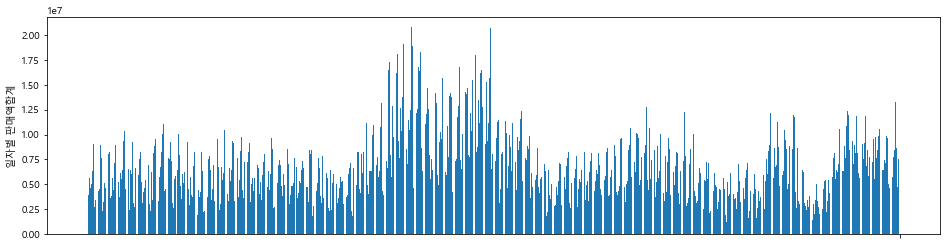

In [3]:
# 전체 판매의 추이 확인 

plt.figure(figsize=(16,4))
dailySales = sales[['datea', 'amt']].groupby('datea').sum().reset_index()
plt.bar(dailySales.datea, dailySales.amt)
plt.ylabel('일자별 판매액합계')
plt.xticks('')
plt.show()

- 전체 매출에서 2020 전년대비 크게 줄어든 양상

### 상품군별 년도별 매출 변화

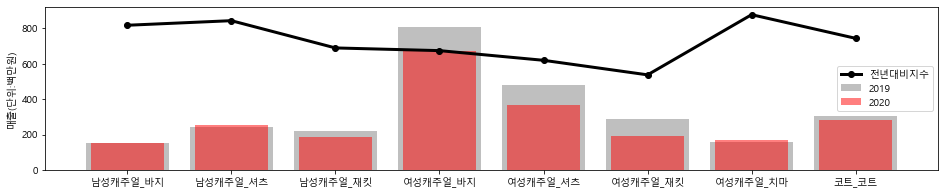

In [4]:
# 대분류 & 소분류 기준으로 금액 집계 -- 2019
ss01 = sales[sales.datea>='2020-01-01'][['lcat', 'scat','amt']].groupby(['lcat', 'scat']).sum().reset_index()
# 대분류와 소분류를 결합한 분류 컬럼 생성
ss01['cat'] = ss01.lcat + '_' +ss01.scat
ss01 = ss01.sort_values(['lcat', 'scat'])
# 대분류 & 소분류 기준으로 금액 집계 -- 전년도
ss02 = sales[sales.datea<'2020-01-01'][['lcat', 'scat','amt']].groupby(['lcat', 'scat']).sum().reset_index()
ss02['cat'] = ss02.lcat + '_' +ss02.scat
ss02 = ss02.sort_values(['lcat', 'scat'])

# 전년과 비교하는 챠트 생성
plt.figure(figsize=(16,3))
plt.bar(ss02.cat, ss02.amt/1000000, alpha=0.5, label='2019', color='grey')
plt.bar(ss01.cat, ss01.amt/1000000, alpha=0.5, width=0.7, label='2020', color='red')

# 전년대비 지수로 두해를 비교하는 값 추가 (착시 방지)
plt.plot(np.arange(len(ss01)),ss01.amt/ss02.amt*  ss02.amt.max()/1000000, 
         color='black', marker='o', linewidth=3, label='전년대비지수')
plt.legend()
plt.ylabel('매출(단위:백만원)')
plt.show()

- 여성캐주얼_셔츠, 여성캐주얼_재킷 등 대부분 상품군에서 전년대비 매출 크게 감소
- 매출비중이 높은 여성캐주얼의 바지와 셔츠 큰 폭 감소가 전체 매출 감소의 대부분을 차지

### 개별 상품별 매출 분포

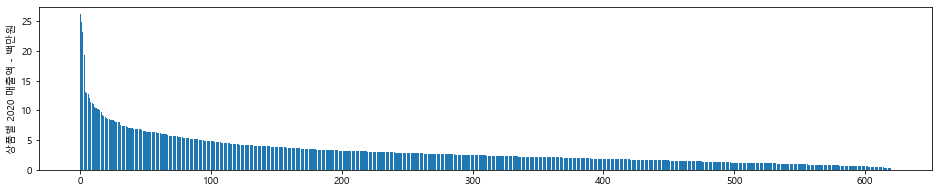

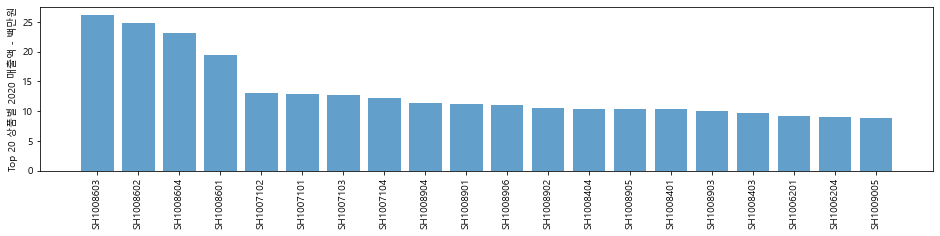

In [5]:
# Shoote 브랜드에 한정한 분석

s901 = sales[(sales.datea>='2020-01-01') & (sales.brand_nm=='Shoote')][['item_id', 'amt']].groupby('item_id').sum().reset_index()
s901 = s901.sort_values('amt', ascending=False)

plt.figure(figsize=(16,3))
plt.bar(np.arange(len(s901)),s901.amt/1000000)
plt.ylabel('상품별 2020 매출액 - 백만원')
plt.show()

s902 = s901.head(20)
plt.figure(figsize=(16,3))
plt.bar(s902.item_id,s902.amt/1000000, alpha=0.7)
plt.ylabel('Top 20 상품별 2020 매출액 - 백만원')
plt.xticks(np.arange(20), s902.item_id, rotation='vertical')
plt.show()


In [6]:
# 다양한 상품속성 중 조회시 사용할 주요 속성 정의
keyItemFeats = ['item_id', 'brand_nm','unit_prc', 'lcat', 'scat', 'color', 'size']

itemmast[itemmast.item_id.isin(s901.head(4).item_id)][keyItemFeats]

,item_id,brand_nm,unit_prc,lcat,scat,color,size
924,SH1008601,Shoote,265000,코트,코트,black,90
925,SH1008602,Shoote,265000,코트,코트,navy,90
926,SH1008603,Shoote,265000,코트,코트,black,95
927,SH1008604,Shoote,265000,코트,코트,navy,95


- 매출이 가장 많은 4개 상품 모두 겨울 코트

### 2019와 2020 두 해의 매출을 상품별로 비교

In [7]:
# 2019년 매출을 상품별로 집계 (Shoote 브랜드 한정)

s903 = sales[(sales.date.str.slice(0,4)=='2019') & (sales.brand_nm=='Shoote')][['item_id', 'amt']].groupby('item_id').sum().reset_index()
s903.columns=['item_id','amt2019']

In [8]:
items2020 = sales[sales.itemyr==2020][['item_id']].drop_duplicates()
items2020 

,item_id
3,SH1008104
7,ES2003604
8,SH1008109
9,SH1008107
10,SH1008906
...,...
15747,ES2004005
17325,ES2003406
18086,ES2004605
21095,ES2003603


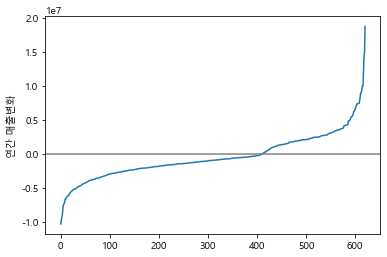

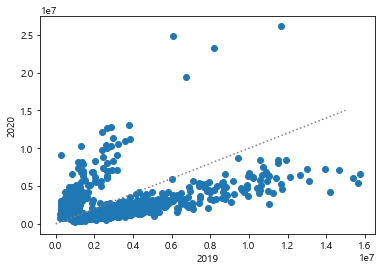

 -- 2019 금액이 가장 작은 10개 상품


,item_id,amt2019,amt2020,amtDiff,amtRInc
507,SH1007406,245000,735000,490000,2.000000
509,SH1007408,245000,1295000,1050000,4.285714
533,SH1007705,252000,2702000,2450000,9.722222
416,SH1006201,265000,9169000,8904000,33.600000
436,SH1006406,280000,2618000,2338000,8.350000
454,SH1006609,280000,3010000,2730000,9.750000
531,SH1007703,280000,2226000,1946000,6.950000
557,SH1008105,300000,3000000,2700000,9.000000
563,SH1008202,300000,1860000,1560000,5.200000
564,SH1008203,300000,1800000,1500000,5.000000


 -- 감소액이 가장 큰 10개 상품


,item_id,amt2019,amt2020,amtDiff,amtRInc
258,SH1003906,15664000,5400000,-10264000,-0.655260
254,SH1003902,14202000,4250000,-9952000,-0.700746
17,SH1000503,15380000,6036000,-9344000,-0.607542
321,SH1004802,15750000,6637000,-9113000,-0.578603
402,SH1005903,11060000,2590000,-8470000,-0.765823
320,SH1004801,14674000,7087000,-7587000,-0.517037
175,SH1002803,13110000,5692000,-7418000,-0.565828
250,SH1003807,11260000,4023000,-7237000,-0.642718
15,SH1000501,11720000,4600000,-7120000,-0.607509
137,SH1002204,13949000,7290000,-6659000,-0.477382


 -- 증가율이 가장 작은 10개 상품


,item_id,amt2019,amt2020,amtDiff,amtRInc
366,SH1005406,5065000,1000000,-4065000,-0.802567
158,SH1002503,2613000,540000,-2073000,-0.793341
402,SH1005903,11060000,2590000,-8470000,-0.765823
147,SH1002401,1540000,385000,-1155000,-0.750000
96,SH1001603,3565000,900000,-2665000,-0.747546
356,SH1005206,6300000,1600000,-4700000,-0.746032
5,SH1000306,2091000,540000,-1551000,-0.741750
148,SH1002402,1330000,350000,-980000,-0.736842
362,SH1005402,7900000,2100000,-5800000,-0.734177
83,SH1001402,2597000,700000,-1897000,-0.730458


In [9]:
# 2019, 2020 두 해 매출 집계를 결합
s904 = s903.merge(s901, how='outer', on='item_id')
s904.columns =['item_id','amt2019', 'amt2020']
s904.fillna(0, inplace=True)

# 결합된 테이블에서 2019년 매출과 2020 매출의 차이 계산
s904['amtDiff'] = s904.amt2020-s904.amt2019
s904['amtRInc'] = (s904.amt2020-s904.amt2019)/s904.amt2019 

# 차이금액의 분포 확인
plt.plot(np.sort(s904['amtDiff']))
plt.axhline(0, color='grey')
plt.ylabel('연간 매출변화')
plt.show()

colors1 = np.where(s904.item_id.isin(sales[sales.itemyr==2020].item_id), 'red', 'blue')
plt.scatter(s904.amt2019, s904.amt2020
           # , color=colors1
           )
plt.xlabel('2019')
plt.ylabel('2020')
plt.plot([0,15000000], [0,15000000], color='grey', linestyle=':')
plt.show()


# 2019 금액이 가장 작은 10개 상품 조회
print(' -- 2019 금액이 가장 작은 10개 상품')
display(s904.nsmallest(10,'amt2019'))

# 차이 금액이 가장 작은 (감소액이 가장 큰) 10개 상품 조회
print(' -- 감소액이 가장 큰 10개 상품')
display(s904.nsmallest(10,'amtDiff'))

# 증가율이 가장 작은 10개 상품 조회
print(' -- 증가율이 가장 작은 10개 상품')
s904.nsmallest(10,'amtRInc')

In [10]:
# 증가액이 가장 큰 상품들의 속성 확인

s905 = s904.nlargest(20,'amtDiff').merge(itemmast[keyItemFeats], how='left', on='item_id')
s905.head(10)

,item_id,amt2019,amt2020,amtDiff,amtRInc,brand_nm,unit_prc,lcat,scat,color,size
0,SH1008602,6095000,24843000,18748000,3.075964,Shoote,265000,코트,코트,navy,90
1,SH1008604,8215000,23211000,14996000,1.825441,Shoote,265000,코트,코트,navy,95
2,SH1008603,11660000,26126000,14466000,1.240652,Shoote,265000,코트,코트,black,95
3,SH1008601,6756000,19384000,12628000,1.869153,Shoote,265000,코트,코트,black,90
4,SH1007103,2660000,12700000,10040000,3.774436,Shoote,190000,남성캐주얼,재킷,grey,90
5,SH1007101,2850000,12872000,10022000,3.516491,Shoote,190000,남성캐주얼,재킷,grey,85
6,SH1007104,2394000,12160000,9766000,4.079365,Shoote,190000,남성캐주얼,재킷,dark blue,90
7,SH1007102,3800000,13062000,9262000,2.437368,Shoote,190000,남성캐주얼,재킷,dark blue,85
8,SH1008401,1320000,10270000,8950000,6.780303,Shoote,200000,코트,코트,black,90
9,SH1006201,265000,9169000,8904000,33.600000,Shoote,265000,여성캐주얼,재킷,navy,95


In [11]:
# 증가액이 가장 작은 (= 감소액이 가장 큰) 상품들의 속성 확인

s906 = s904.nsmallest(30,'amtDiff').merge(itemmast[keyItemFeats], how='left', on='item_id')
s906.head(10)

,item_id,amt2019,amt2020,amtDiff,amtRInc,brand_nm,unit_prc,lcat,scat,color,size
0,SH1003906,15664000,5400000,-10264000,-0.655260,Shoote,250000,여성캐주얼,재킷,light grey,105
1,SH1003902,14202000,4250000,-9952000,-0.700746,Shoote,250000,여성캐주얼,재킷,light grey,95
2,SH1000503,15380000,6036000,-9344000,-0.607542,Shoote,230000,코트,코트,black,95
3,SH1004802,15750000,6637000,-9113000,-0.578603,Shoote,250000,코트,코트,navy,90
4,SH1005903,11060000,2590000,-8470000,-0.765823,Shoote,185000,코트,코트,black,95
5,SH1004801,14674000,7087000,-7587000,-0.517037,Shoote,250000,코트,코트,black,90
6,SH1002803,13110000,5692000,-7418000,-0.565828,Shoote,230000,남성캐주얼,재킷,grey,90
7,SH1003807,11260000,4023000,-7237000,-0.642718,Shoote,145000,여성캐주얼,셔츠,white,100
8,SH1000501,11720000,4600000,-7120000,-0.607509,Shoote,230000,코트,코트,black,90
9,SH1002204,13949000,7290000,-6659000,-0.477382,Shoote,180000,남성캐주얼,재킷,dark blue,90


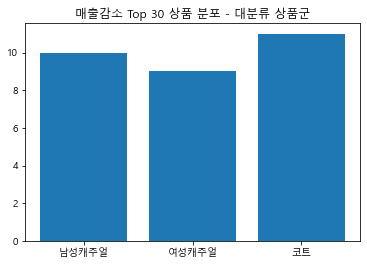

In [12]:
# 증가액이 가장 작은 (= 감소액이 가장 큰) 상품들이 속하는 상품군 대분류 분포

plt.bar(cntnpcnt(s906.lcat).lcat, cntnpcnt(s906.lcat).recCnt)
plt.title('매출감소 Top 30 상품 분포 - 대분류 상품군')
plt.show()

- 상품수와 매출 비중이 크지 않은 코트들이 많이 매출 감소

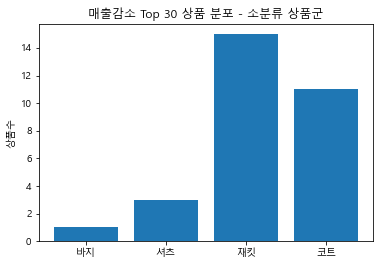

In [13]:
# 소분류 분포

plt.bar(cntnpcnt(s906.scat).scat, cntnpcnt(s906.scat).recCnt)
plt.title('매출감소 Top 30 상품 분포 - 소분류 상품군')
plt.ylabel('상품수')
plt.show()

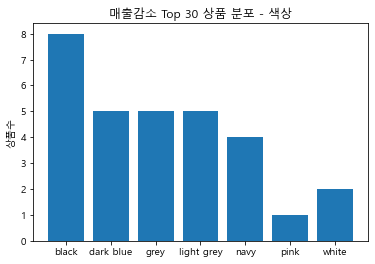

In [14]:
# 색상의 분포

plt.bar(cntnpcnt(s906.color).color, cntnpcnt(s906.color).recCnt)
plt.title('매출감소 Top 30 상품 분포 - 색상')
plt.ylabel('상품수')
plt.show()

#### 박스플롯 활용 -- 개별상품의 변화 분포를 확인

['여성캐주얼' '남성캐주얼' '코트']


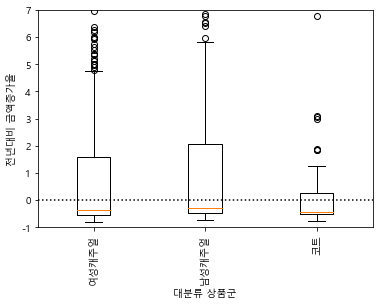

In [15]:
s911 = s904.merge(itemmast[keyItemFeats], how='left', on='item_id')

# 표시한 데이터를 담을 빈 리스트 정의
dataList = []
print(s911.lcat.unique())

for x in s911.lcat.unique():
    # 반복문을 사용해 각 대분류별 값을 리스트에 추가
    dataList.append(s911[s911.lcat==x].amtRInc)

# 한번에 리스트 안의 데이터를 박스플롯 생성    
plt.boxplot(dataList)
# 분류명을 표시할 좌표는 1 부터 (즉 0 + 1)
plt.xticks(np.arange(len(s911.lcat.unique()))+1, 
           s911.lcat.unique(), 
           rotation=90)
plt.xlabel('대분류 상품군')
plt.ylabel('전년대비 금액증가율')
# 아웃라이어 때문에 대부분의 값들이 위치한 부분이 작게 나타나는 것 방지
plt.ylim(-1,7)
plt.axhline(0, color='k', linestyle=':')
plt.show()

- 세가지 대분류 모두 중간값(orange) 위치가 0보다 크게 작음 - 매출감소의 의미
- 단, 각 상품군에서 일부 상품은 크게 증가한 것들도 존재 (outlier?)
- 100% 이상의 증가 정도는 흔히 발생 가능한 수준
- (코트를 제외한 나머지 두개 상품군은 박스의 상단이 1 보다 위에 있음)

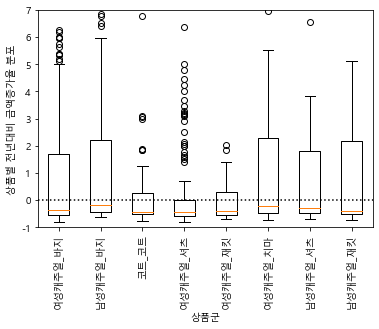

In [16]:
# 대분류별 소분류 (결합한 분류)

s911['lscat'] = s911.lcat + '_' + s911.scat

dataList = []
lscatList = s911.lscat.unique()

for x in s911.lscat.unique():
    dataList.append(s911[s911.lscat==x].amtRInc)

plt.boxplot(dataList)
plt.xticks(np.arange(len(s911.lscat.unique()))+1, s911.lscat.unique(),
           rotation=90)
plt.xlabel('상품군')
plt.ylabel('상품별 전년대비 금액증가율 분포')
plt.ylim(-1,7)
plt.axhline(0, color='k', linestyle=':')
plt.show()

- 여성캐주얼 셔츠는 큰 편차도 없이 대부분 상품이 매출 감소한 패턴

#### 상품군별 추이 시계열 비교

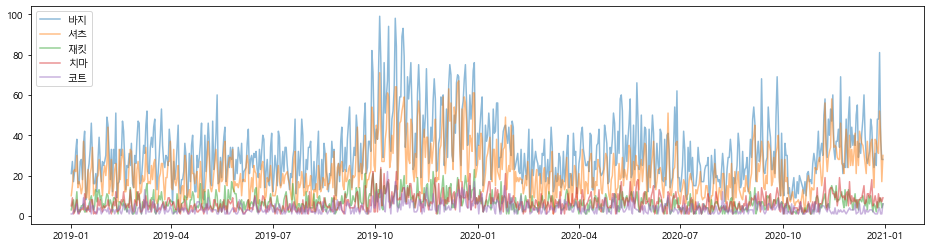

In [17]:
## 소분류별 매출 변화 추이 비교 시계열 - 일단위 집계

scatSaleseries = sales[['scat','datea','qty']].groupby(['scat','datea']).sum().reset_index()

plt.figure(figsize=(16,4))
# 반복문을 사용해서 분류 하나 마다의 시계열 데이터 표시
for x in scatSaleseries.scat.unique():
    plt.plot(pd.to_datetime(scatSaleseries[scatSaleseries.scat==x].datea), scatSaleseries[scatSaleseries.scat==x].qty, 
             label=x, alpha=0.5)
plt.legend()
plt.show()


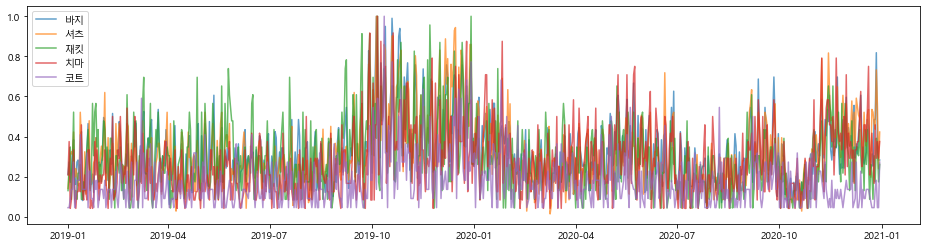

In [18]:
# 비교를 위해 scaling 적용 - 척도 통일

plt.figure(figsize=(16,4))
for x in scatSaleseries.scat.unique():
    plt.plot(pd.to_datetime(scatSaleseries[scatSaleseries.scat==x].datea), zrmx_scl(scatSaleseries[scatSaleseries.scat==x].qty), 
             label=x, alpha=0.7)
plt.legend()
plt.show()

- 스케일을 통일한 것은 바람직했으나 스파이크가 겹쳐서 구별이 어려움

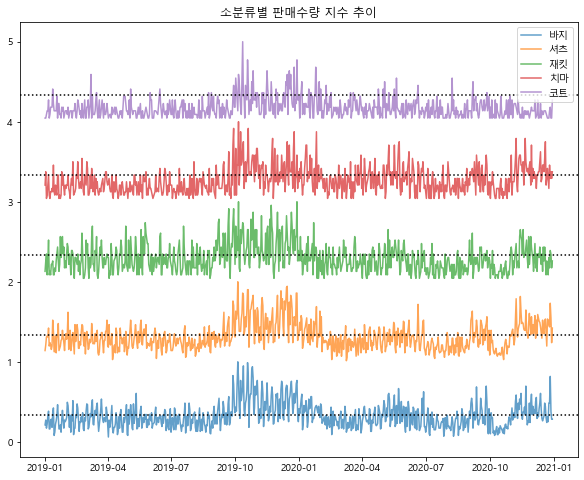

In [19]:
# 통일된 스케일을 사용하지만 각각을 일정 간격을 둔 범위에 따라 분리해 표시하는 방식 

plt.figure(figsize=(10,8))
for i, x in enumerate(scatSaleseries.scat.unique()):
    plt.plot(pd.to_datetime(scatSaleseries[scatSaleseries.scat==x].datea), 
             # 순서만큼 위 쪽으로 올라가면서 표시
             zrmx_scl(scatSaleseries[scatSaleseries.scat==x].qty) + i, 
             label=x, alpha=0.7)
    
    # 패턴의 고점과 저점을 비교할 수 있도록 동일한 보조선을 추가
    plt.axhline(i+0.33, color='k', linestyle=':')
    
plt.legend()
plt.title('소분류별 판매수량 지수 추이')
plt.show()

- 코트가 전년과 달리 2020년 겨울 증가하지 못한 패턴을 상대적인 비교로 파악 가능

- 일별로 분석하면 스파이크가 심해서 여전히 패턴 이해가 어려움 --> 월별로 집계해서 본다면?

,lcat,datea,qty,yearMon
0,남성캐주얼,2019-10-26,1,2019-10
1,여성캐주얼,2019-10-28,2,2019-10
2,남성캐주얼,2019-01-01,1,2019-01
3,여성캐주얼,2019-09-28,1,2019-09
4,여성캐주얼,2019-01-01,1,2019-01


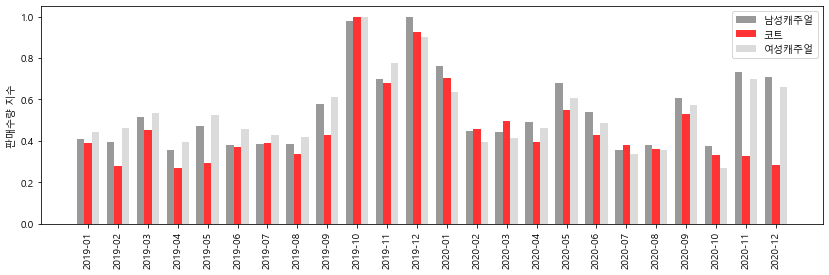

In [20]:
## 소분류별 매출 변화 추이 비교 시계열 - 월별 집계 기준

salesTmp = sales[['lcat','datea','qty']].copy()
salesTmp['yearMon'] = pd.to_datetime(salesTmp['datea']).dt.to_period('M')
display(salesTmp.head())

lcatSaleseries = salesTmp[['lcat','yearMon','qty']].groupby(['lcat','yearMon']).sum().reset_index()

# 여러개 bar chart를 옆으로 배치 (그룹별) 하는 경우
# X축의 순서가 섞이지 않도록 미리 정렬
lcatSaleseries = lcatSaleseries.sort_values('yearMon')

colors1 = ['grey', 'red',  'lightgrey']

plt.figure(figsize=(14,4))
for i, x in enumerate(lcatSaleseries.lcat.unique()):
    # X축 좌표 기준점 보다 약간 왼쪽에 막대 표시
    tmpData = lcatSaleseries[lcatSaleseries.lcat==x]
    # X축의 좌표
    X_axis = np.arange(len(tmpData))
    # 막대의 위치를 중심에서 왼쪽에서 출발해서 하나씩
    # 막대의 폭은 모든 막대를 표시할 수 있도록 좁혀서
    plt.bar(X_axis - 0.25 + (i*0.25), zrmx_scl(tmpData.qty), width=0.25, label = x,
           alpha=0.8,
           color=colors1[i])

# X축의 좌표별 label
plt.xticks(X_axis, lcatSaleseries.yearMon.unique(),
          rotation=90)
plt.ylabel('판매수량 지수')
# 이미 지정된 label 들을 사용해서 범례 일괄 표시
plt.legend()
plt.show()

## 판매부진 상품의 상품속성 분석

In [21]:
# 비싼 상품이 더 떨 어졌나? 싼 상품이 떨어졌나?

tmpSales = sales[['item_id', 'date', 'amt']].copy()
tmpSales['saleYr'] = tmpSales.date.str.slice(0,4)
tmpSales = tmpSales[['item_id', 'saleYr', 'amt']]

s701 = tmpSales[['item_id', 'saleYr', 'amt']].groupby(['saleYr','item_id']).sum().reset_index()
s701 = s701.pivot(index='item_id', columns='saleYr', values ='amt').reset_index()
s701.columns = ['item_id', 'amt2019', 'amt2020']
s701.fillna(0, inplace=True)
s701 = s701[s701.amt2019>0]
s701['rChng'] = s701.amt2020 / s701.amt2019


s701 = s701.merge(itemmast[['item_id','unit_prc']], how='left', on='item_id')
s701

,item_id,amt2019,amt2020,rChng,unit_prc
0,ES2000501,12352000.0,2790000.0,0.225874,155000
1,ES2000502,14196000.0,6200000.0,0.436743,155000
2,ES2000503,7857000.0,3061000.0,0.389589,155000
3,ES2000504,12085000.0,6975000.0,0.577162,155000
4,ES2000505,9266000.0,2015000.0,0.217462,155000
...,...,...,...,...,...
940,SH1009002,2640000.0,6060000.0,2.295455,60000
941,SH1009003,1260000.0,4920000.0,3.904762,60000
942,SH1009004,2700000.0,6960000.0,2.577778,60000
943,SH1009005,2460000.0,8880000.0,3.609756,60000


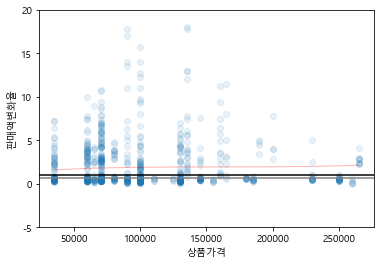

('corr : ', 0.03354338196782063)

In [22]:
plt.scatter(s701.unit_prc, s701.rChng, alpha=0.1)
varx = s701.unit_prc
vary = s701.rChng
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 3))(np.unique(varx)), 
         color='red', linewidth=1, alpha=0.3)
plt.ylim(-5,20)
plt.axhline(1, color='k')
plt.axhline(np.median(vary), color='grey')
plt.xlabel('상품가격')
plt.ylabel('판매액변화율')
plt.show()

'corr : ', np.corrcoef(s701.unit_prc, s701.rChng)[0,1]

(147, 5)


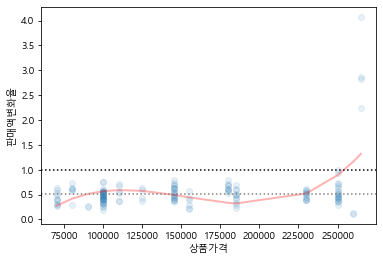

('corr : ', 0.29681034726534566)

In [23]:
s702 = s701[s701.amt2019>=0.5e+7]
print(s702.shape)

plt.scatter(s702.unit_prc, s702.rChng, alpha=0.1)
varx = s702.unit_prc
vary = s702.rChng
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 3))(np.unique(varx)), 
         color='red', linewidth=2, alpha=0.3)

plt.axhline(1, color='k',linestyle=':')
plt.axhline(np.median(vary), color='grey', linestyle=':')
plt.xlabel('상품가격')
plt.ylabel('판매액변화율')

plt.show()

'corr : ', np.corrcoef(s702.unit_prc, s702.rChng)[0,1]

#### 판매금액 대신 수량을 사용해 가격과 교차한 분석

In [24]:
tmpSales1 = sales[['item_id', 'date', 'qty']].copy()
tmpSales1['saleYr'] = tmpSales1.date.str.slice(0,4)
tmpSales1 = tmpSales1[['item_id', 'saleYr', 'qty']]

s703 = tmpSales1[['item_id', 'saleYr', 'qty']].groupby(['saleYr','item_id']).sum().reset_index()
s703 = s703[s703.saleYr=='2019'][['item_id','qty']]
s703.columns = ['item_id','qty2019']

s701 = s701.merge(s703, how='left', on='item_id')
s701

,item_id,amt2019,amt2020,rChng,unit_prc,qty2019
0,ES2000501,12352000.0,2790000.0,0.225874,155000,80
1,ES2000502,14196000.0,6200000.0,0.436743,155000,92
2,ES2000503,7857000.0,3061000.0,0.389589,155000,51
3,ES2000504,12085000.0,6975000.0,0.577162,155000,79
4,ES2000505,9266000.0,2015000.0,0.217462,155000,60
...,...,...,...,...,...,...
940,SH1009002,2640000.0,6060000.0,2.295455,60000,44
941,SH1009003,1260000.0,4920000.0,3.904762,60000,21
942,SH1009004,2700000.0,6960000.0,2.577778,60000,45
943,SH1009005,2460000.0,8880000.0,3.609756,60000,41


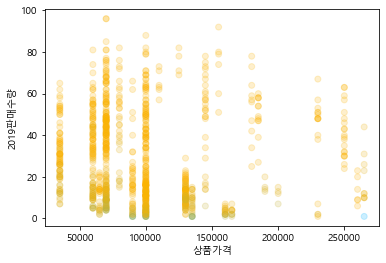

In [25]:
# 두 변수를 사용한 산점도에 색상으로 변화율 표시

# 변화율이 크면 yellow, 작으면 파란색. 연속값으로 색상 지정
# 0~1 값으로 RGB 색상을 지정하므로 scaling
colors1 = [[1-z,0.7,z]  for z in mnmx_scl(s701.rChng)]

# 판매액은 가격이 곱해진 것이지만 수량은 별개
plt.scatter(s701.unit_prc, s701.qty2019, 
            alpha=0.2,
            color=colors1)
plt.xlabel('상품가격')
plt.ylabel('2019판매수량')
plt.show()

- 상품가격과 판매수량간의 관계는 상당히 분산된 모습
- 가격대와는 상관이 크지 않고 2019 판매수량이 작은 쪽에서 전년대비판매액 크게 감소

### 상품별 고객의 특성을 사용한 상품분석

- 매출 부진 상품 분석 에서 2019 기준 고객층 (연령) 중심으로 파악해 본다면?
- 예: 2019 기준 여성이 주로 구매하던 상품들이 매출이 많이 줄었다 ?

In [26]:
tmpSales3 = sales[['item_id', 'date', 'cust_id']].copy()
tmpSales3 = tmpSales3.merge(custmast[['cust_id', 'age']], how='left', on='cust_id')

tmpSales3['saleYr'] = tmpSales3.date.str.slice(0,4)
tmpSales3 = tmpSales3[['item_id', 'saleYr', 'age']]

s704 = tmpSales3[['item_id', 'saleYr', 'age']].groupby(['saleYr','item_id']).mean().reset_index()
s704 = s704[s704.saleYr=='2019'][['item_id','age']]
s704.columns = ['item_id','age2019']

s701 = s701.merge(s704, how='left', on='item_id')
s701.age2019.fillna(s701.age2019.median(), inplace=True)
s701

,item_id,amt2019,amt2020,rChng,unit_prc,qty2019,age2019
0,ES2000501,12352000.0,2790000.0,0.225874,155000,80,33.275862
1,ES2000502,14196000.0,6200000.0,0.436743,155000,92,35.382979
2,ES2000503,7857000.0,3061000.0,0.389589,155000,51,36.545455
3,ES2000504,12085000.0,6975000.0,0.577162,155000,79,34.250000
4,ES2000505,9266000.0,2015000.0,0.217462,155000,60,33.076923
...,...,...,...,...,...,...,...
940,SH1009002,2640000.0,6060000.0,2.295455,60000,44,35.117647
941,SH1009003,1260000.0,4920000.0,3.904762,60000,21,38.800000
942,SH1009004,2700000.0,6960000.0,2.577778,60000,45,38.880000
943,SH1009005,2460000.0,8880000.0,3.609756,60000,41,36.450000


In [27]:
s701.age2019.fillna(s701.age2019.median(), inplace=True)
s701

,item_id,amt2019,amt2020,rChng,unit_prc,qty2019,age2019
0,ES2000501,12352000.0,2790000.0,0.225874,155000,80,33.275862
1,ES2000502,14196000.0,6200000.0,0.436743,155000,92,35.382979
2,ES2000503,7857000.0,3061000.0,0.389589,155000,51,36.545455
3,ES2000504,12085000.0,6975000.0,0.577162,155000,79,34.250000
4,ES2000505,9266000.0,2015000.0,0.217462,155000,60,33.076923
...,...,...,...,...,...,...,...
940,SH1009002,2640000.0,6060000.0,2.295455,60000,44,35.117647
941,SH1009003,1260000.0,4920000.0,3.904762,60000,21,38.800000
942,SH1009004,2700000.0,6960000.0,2.577778,60000,45,38.880000
943,SH1009005,2460000.0,8880000.0,3.609756,60000,41,36.450000


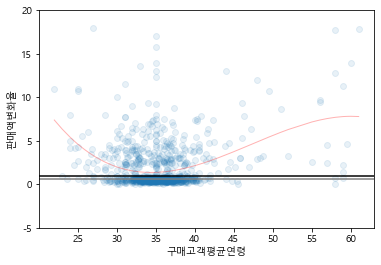

('corr : ', 0.1845222629420887)

In [28]:
varx = s701.age2019
vary = s701.rChng
plt.scatter(varx,vary, alpha=0.1)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 3))(np.unique(varx)), 
         color='red', linewidth=1, alpha=0.3)
plt.ylim(-5,20)
plt.axhline(1, color='k')
plt.axhline(np.median(vary), color='grey')
plt.xlabel('구매고객평균연령')
plt.ylabel('판매액변화율')
plt.show()

'corr : ', np.corrcoef(s701.age2019, s701.rChng)[0,1]

### 의사결정나무를 사용한 매출부진 상품 특성 파악

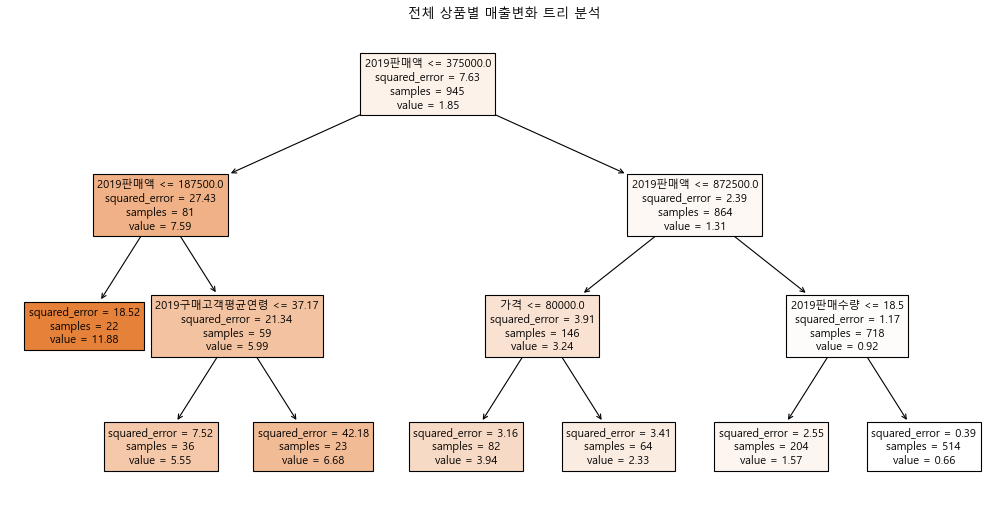

In [29]:
from sklearn.tree import DecisionTreeRegressor  # 의사결정나무 모듈 불러오기
from sklearn import tree # 의사결정나무 시각화 모듈 불러오기

# 모형의 옵션 지정
dt = DecisionTreeRegressor(max_depth=3, # 트리가 너무 커지지 않도록
                           min_samples_leaf=20) # 한 집단에 너무 작은 수의 표본이 들어가지 않도록

# X 변수 지정 
dtfeatures = ['amt2019', 'unit_prc',  'qty2019', 'age2019']
# 트리 시각화에서 표시할 이름 (한글)
dtfeature_nms = ['2019판매액' , '가격', '2019판매수량', '2019구매고객평균연령']

# 모형에 데이터를 대입해 모형 완성
dt.fit(s701[dtfeatures], s701['rChng'])

# 생성된 트리 모형의 시각화
plt.figure(figsize=(16,8), dpi=80)
tree.plot_tree(dt, 
               feature_names=dtfeature_nms, 
               filled=True, 
               fontsize=10, 
               precision=2)
plt.title('전체 상품별 매출변화 트리 분석')
plt.show()

- 판매액에는 가격이 반영되어있어서 판매액, 가격, 판매수량 간에 복잡한 관계 나타남
- **[트리분석 결과의 핵심]** 2020 매출이 전년대비 크게 감소한 상품은 2019 판매수량이 많았던 상품들 (전체 상품수의 절반 이상)
- 2019판매액이 극히 작았던 소수의 상품들의 증가는 단순히 2019판매액이 작았기 때문으로 풀이됨
- 가격 낮은 편의 상품 중 일부는 판매 크게 증가 (--> **한시적인 가격할인 프로모션**, **저가형 상품 집중 마케팅** 등 검토 필요)

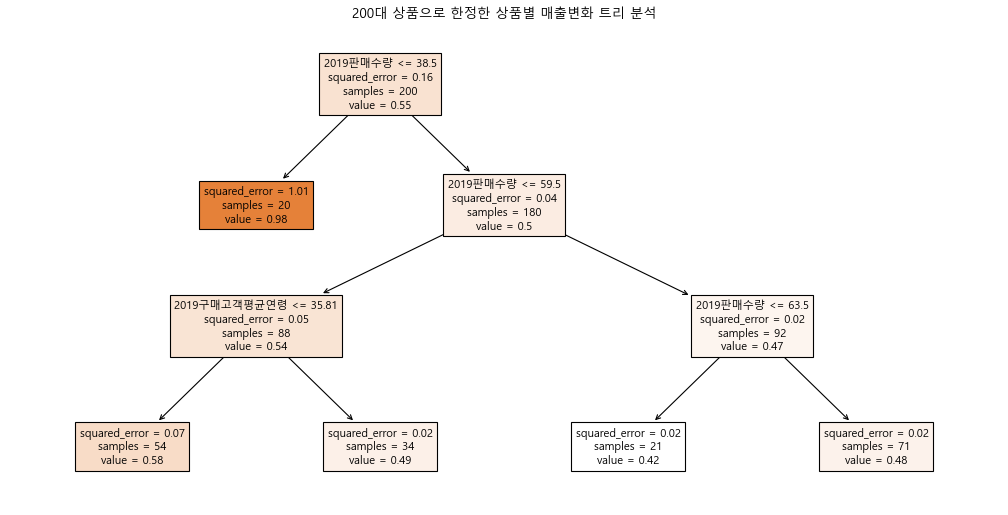

In [30]:
# 분석대상을 2019 판매액 200대 상품으로 한정
s701s = s701.sort_values('amt2019', ascending=False).head(200)

# 모형에 데이터를 대입해 모형 완성
dt.fit(s701s[dtfeatures], s701s['rChng'])

# 생성된 트리 모형의 시각화
plt.figure(figsize=(16,8), dpi=80)
tree.plot_tree(dt, 
               feature_names=dtfeature_nms, 
               filled=True, 
               fontsize=10, 
               precision=2)
plt.title('200대 상품으로 한정한 상품별 매출변화 트리 분석')
plt.show()

- 200대 상품으로 한정한 분석에서는 2019판매수량이 상대적으로 많은 상품 쪽이 감소폭 더 큼
- 평균연령이 많은 쪽이 좀 더 감소폭 큼

- 의사결정나무를 사용한 분석은 전체 보다는 국지적 패턴을 보여주므로 보완적으로 **상관분석**도 실시

In [31]:
# 상관관계 분석 - 전체 상품 대상

s701[['amt2019', 'unit_prc',  'qty2019', 'age2019','rChng']].corr()

,amt2019,unit_prc,qty2019,age2019,rChng
amt2019,1.000000,0.506238,0.759231,-0.039625,-0.360496
unit_prc,0.506238,1.000000,-0.056199,0.016985,0.033543
qty2019,0.759231,-0.056199,1.000000,-0.042298,-0.475708
age2019,-0.039625,0.016985,-0.042298,1.000000,0.184522
rChng,-0.360496,0.033543,-0.475708,0.184522,1.000000


- 상관계수 절대값만 보면 2019 판매수량이 금액보다도 판매액 변화와 강한 관계

## 분석결과 종합

- 주력인 여성캐주얼 상품의 판매가 전년대비 크게 감소
- 판매량, 금액이 많은 주요 상품들의 감소 큼
- 여성 캐주얼 셔츠 감소 특히 큼
<br><br>
- 가격 낮은 편의 상품 중 일부는 판매 크게 증가 (--> **한시적인 가격할인 프로모션**, **저가형 상품 집중 마케팅** 등 **단기적인 대책** 검토 필요)